# Shape Interpolation

In [1]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

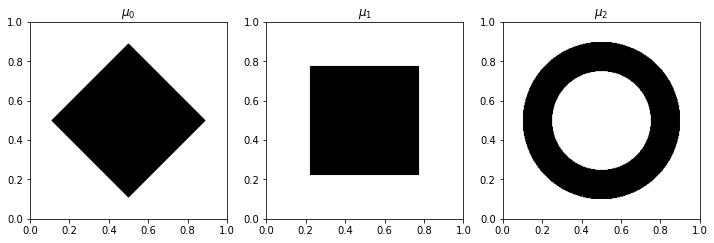

In [2]:
# Grid of size n1 x n2
n1 = 256   # x axis
n2 = 256 # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))



r1 = 0.25
r2 = 0.4
circle = np.zeros((n1,n2))
circle[ (np.sqrt((x-0.5)**2 + (y-0.5)**2)>r1) & (np.sqrt((x-0.5)**2 + (y-0.5)**2)<r2) ] = 1.0

L = np.sqrt(np.pi*(r2**2-r1**2))
square = np.zeros((n1,n2))
square[ (np.abs(x-0.5)<0.5*L) & (np.abs(y-0.5)<0.5*L)] = 1.0

diamond = np.zeros((n1,n2))
diamond[ (np.abs(x+y-1)<0.5*L*np.sqrt(2)) * (np.abs(x-y)<0.5*L*np.sqrt(2))] = 1.0

measures = [diamond, square, circle]

# Normalize all the measures
for i in range(len(measures)):
    measures[i] *= n1*n2 / np.sum(measures[i])

fig, ax = plt.subplots(1, len(measures), figsize=(12,4))
for i in range(len(measures)):
    ax[i].imshow(measures[i], origin='lower', extent=(0,1,0,1), cmap='Greys')
    ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

In [3]:
def Solve(bary_weights):
    unroll_node = 1
    bary_weights /= np.sum(bary_weights)

    # Only keep the measures with positive weights
    keep_inds = np.where(bary_weights>0)[0]
    bary_weights = bary_weights[keep_inds]
    if(len(keep_inds)==1):
        return measures[keep_inds[0]]
    
    keep_measures = [measures[i] for i in keep_inds]

    # Construct the edge list for the barycenter problem
    edge_list = []
    for i in range(len(keep_inds)):
        for j in range(i+1,len(keep_inds)):
            edge_list.append([i,j])

    # Set up the MMOT solver
    prob = MMOTSolver(keep_measures, edge_list, x, y, unroll_node, bary_weights)
    dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

    num_its = 500
    step_size = 0.1
    costs = np.nan*np.zeros(num_its)

    ftol = 1e-11
    gtol = 1e-4

    root_nodes = np.arange(prob.NumDual())
    root_cycler = itertools.cycle(root_nodes)

    print('Iteration, StepSize,    Cost,   Error')
    for i in range(num_its):
        error = prob.Step(next(root_cycler), dual_vars, step_size)
        
        costs[i] = prob.ComputeCost(dual_vars)
        if(i>0):
            step_size = prob.StepSizeUpdate(step_size, costs[i], costs[i-1], error)

        if((i%50)==0):
            print('{:9d},   {:0.4f},  {:0.4f},   {:0.5f}'.format(i,step_size, costs[i], error), flush=True)

        # Check for convergence in cost
        if(np.abs(costs[i]-costs[i-1])<ftol):
            print('Converged because of small change in objective.')
            break

        # Check for convergence via gradient 
        if(error<gtol):
            print('Converged because of gradient norm.')
            break 
    
    return prob.Barycenter(dual_vars)

1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0014,   0.03547
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0018,   0.03547
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0014,   0.03547
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0014,   0.03536
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0004,   0.07321
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  -0.0000,   0.07321
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0001,   0.00238
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0018,   0.03536
Converged because of gradient norm.
1
Iteration, StepSize,    Cost,   Error
        0,   0.1000,  0.0005,  

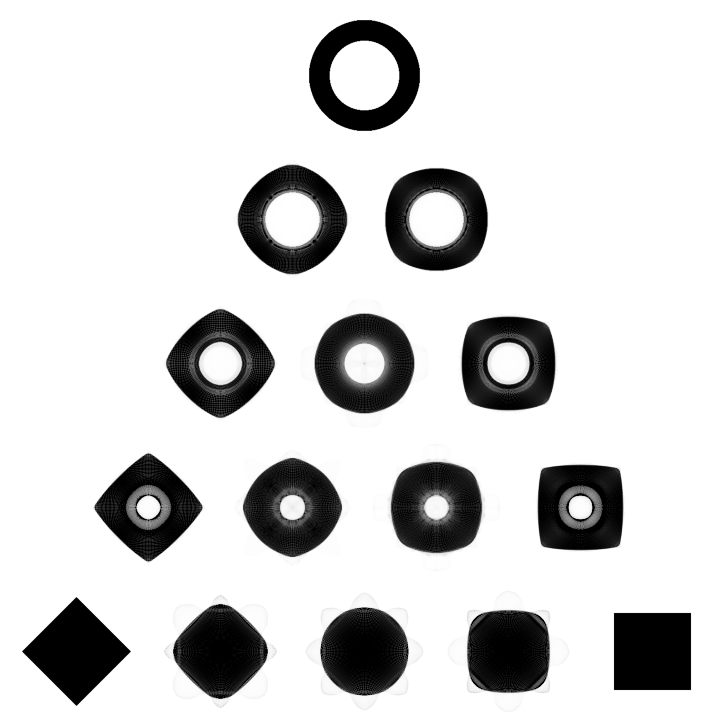

In [4]:
fig=plt.figure(figsize=(8,8)) 

vmax = np.max(measures[0])

size=0.24
corner_pos = np.array([[0.0,0.0], [1.0,0.0], [0.5,1]])

for i,m in enumerate(measures):
    ax=fig.add_axes([corner_pos[i,0],corner_pos[i,1],size,size])
    ax.imshow(measures[i],extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()


for w1 in [0,0.25,0.5,0.75,1.0]:
    for w2 in [0.0,0.25,0.5,0.75,1.0]:
        w3 = 1.0 - w2 - w1 
        if(w3>=0):
            weights = np.array([w1,w2,w3])
            avg_pos = (weights.reshape(1,3) @ corner_pos)[0]
            
            bary = Solve(weights)

            avg_pos = (weights.reshape(1,3) @ corner_pos)[0]
            ax=fig.add_axes([avg_pos[0],avg_pos[1],size,size])
            ax.imshow(bary,extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
            ax.set_axis_off()